# Known issues

## A float quantity is Iterable
https://docs.python.org/3/library/collections.abc.html#collections.abc.Iterable
This tests if the object has "__iter__"

In [1]:
import collections
from physipy import m

isinstance(m, collections.abc.Iterable)

True

## Array repr with 0 value
Pick best favunit take the smallest when 0 is in the array with positiv and negativ values

In [2]:
from physipy import m, Quantity, Dimension
import numpy as np
Quantity(np.array([0, -1.2, 1.2]), Dimension("L"))

<Quantity : [ 0.  -1.2  1.2] m>

# Inplace change using asqarray

In [10]:
from physipy.quantity.utils import asqarray
print(type(m.value))
arrq_9 = np.array([m.__copy__()], dtype=object)
out = asqarray(arrq_9)
# this changes the type of m value
print(type(m.value))

<class 'int'>
<class 'int'>


# Numpy trapz implementaion not called when only x or dx is a quantity

https://github.com/numpy/numpy/issues/18902

Only work when the array to integrate is a quantity

In [1]:
from physipy import m
import numpy as np

In [13]:
# this works
print(np.trapz(np.arange(5)*m))
# also this
print(np.trapz(np.arange(5), x=np.arange(5)*m))
print(np.trapz(np.arange(5), dx=5000*m, x=np.arange(5)*m)) #dx is silent
# but not this
#np.trapz(np.arange(5), dx=5000*m)
print("----uncomment above line to trigger exception")

into array function
8.0 m
into array function
8.0 m
into array function
8.0 m
----uncomment above line to trigger exception


# Array function interface not triggered on scalars

Calling a numpy function with only scalars will not trigger the array function interface, since it is used only when an argument is an array.

In [15]:
from physipy import m
# this raises a DimensionError because of the casting into float
#np.random.normal(3*m, 1*m)
# while this works
np.random.normal(np.array(3*m), np.array(1*m))

2.4153630235574304

# FIXED (Matplotlib histogram) by adding "to_numpy" method

It turns out that matplotlib first checks if the object has a "to_numpy()" method, then again improved by removing to_numpy and removing __iter__ and delegate it to getattr

Some preprocessing turn a quantity-array into a "set of elements", and plots one histogram for each value.

In [1]:
import numpy as np
from physipy import m
import matplotlib.pyplot as plt

In [2]:
arr = np.random.normal(1, 0.1, size=100)*m

(array([ 4.,  6.,  9., 12.,  9., 18., 18., 15.,  4.,  5.]),
 array([0.76964509, 0.81419341, 0.85874173, 0.90329005, 0.94783837,
        0.99238669, 1.03693502, 1.08148334, 1.12603166, 1.17057998,
        1.2151283 ]),
 <BarContainer object of 10 artists>)

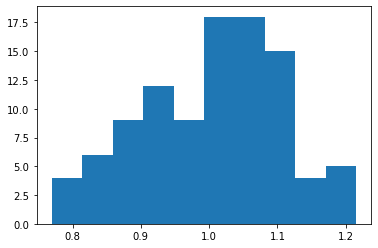

In [3]:
plt.hist(arr.value)

/Users/mocquin/MYLIB10/MODULES/physipy/physipy/quantity/quantity.py:664: UserWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.")


(array([ 4.,  6.,  9., 12.,  9., 18., 18., 15.,  4.,  5.]),
 array([0.76964509, 0.81419341, 0.85874173, 0.90329005, 0.94783837,
        0.99238669, 1.03693502, 1.08148334, 1.12603166, 1.17057998,
        1.2151283 ]),
 <BarContainer object of 10 artists>)

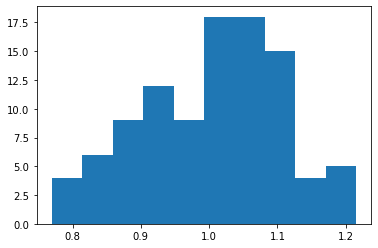

In [4]:
plt.hist(arr)

# Matplotlib histogram, again : missing units support

Source code for hist : https://matplotlib.org/stable/_modules/matplotlib/axes/_axes.html#Axes.hist

One of the first things done is : 
```python
x = cbook._reshape_2D(x, 'x')
```
With 
```python
Signature: cbook._reshape_2D(X, name)
Source:   
def _reshape_2D(X, name):
    """
    Use Fortran ordering to convert ndarrays and lists of iterables to lists of
    1D arrays.

    Lists of iterables are converted by applying `np.asanyarray` to each of
    their elements.  1D ndarrays are returned in a singleton list containing
    them.  2D ndarrays are converted to the list of their *columns*.

    *name* is used to generate the error message for invalid inputs.
    """

    # unpack if we have a values or to_numpy method.
    try:
        X = X.to_numpy()
    except AttributeError:
        try:
            if isinstance(X.values, np.ndarray):
                X = X.values
        except AttributeError:
            pass

    # Iterate over columns for ndarrays.
    if isinstance(X, np.ndarray):
        X = X.T

        if len(X) == 0:
            return [[]]
        elif X.ndim == 1 and np.ndim(X[0]) == 0:
            # 1D array of scalars: directly return it.
            return [X]
        elif X.ndim in [1, 2]:
            # 2D array, or 1D array of iterables: flatten them first.
            return [np.reshape(x, -1) for x in X]
        else:
            raise ValueError(f'{name} must have 2 or fewer dimensions')

    # Iterate over list of iterables.
    if len(X) == 0:
        return [[]]

    result = []
    is_1d = True
    for xi in X:
        # check if this is iterable, except for strings which we
        # treat as singletons.
        if (isinstance(xi, collections.abc.Iterable) and
                not isinstance(xi, str)):
            is_1d = False
        xi = np.asanyarray(xi)
        nd = np.ndim(xi)
        if nd > 1:
            raise ValueError(f'{name} must have 2 or fewer dimensions')
        result.append(xi.reshape(-1))

    if is_1d:
        # 1D array of scalars: directly return it.
        return [np.reshape(result, -1)]
    else:
        # 2D array, or 1D array of iterables: use flattened version.
        return result
```

In [1]:
import matplotlib.pyplot as plt
from physipy import units, m, K, setup_matplotlib
from matplotlib import cbook
import numpy as np

In [2]:
arr = np.random.normal(1, 0.1, size=100)*m
setup_matplotlib()

in getattr with to_numpy
in getattr with values
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_stru

/Users/mocquin/MYLIB10/MODULES/physipy/physipy/quantity/quantity.py:665: UserWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.")


(array([ 2.,  4., 14., 15., 23., 17., 19.,  3.,  1.,  2.]),
 array([0.75893981, 0.8151845 , 0.87142919, 0.92767388, 0.98391857,
        1.04016326, 1.09640795, 1.15265264, 1.20889733, 1.26514202,
        1.32138671]),
 <BarContainer object of 10 artists>)

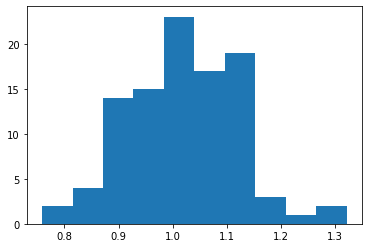

In [3]:
plt.hist(arr)

I created a [unit package for physical computation](https://github.com/mocquin/physipy) and its [matplotlib' unit interface](https://github.com/mocquin/physipy/blob/master/physipy/quantity/plot.py) that works well for plotting with `Axes` methods like `ax.plot`, as you can see in the [plotting notebooke demo](https://github.com/mocquin/physipy/blob/master/docs/Plotting.ipynb).
The issue I am facing is to have the unit interface work with the histogram plotting, like in `ax.hist(arr)`.

For now, I have 2 solutions that are not satisfiying : 
 - first solution is the current state of my project : I added to my `Quantity` object a `to_numpy()` method that cast the instance into a plain numpy array, which makes the histogram plotting work, but looses the automatic unit plotting, since it is not a Quantity anymore but a plain numpy array. For some reasons, this method is never used when plotting with `ax.plot`, but is one of the first things tried when using `ax.hist`.
 - other solution is what I had until recently, which was even worse : without the `to_numpy()` method, matplotlib tries to loop inside the object, and since my object can be iterated over (if it is a 1D array for eg), then it plots one 1-element-histogram for each value. You can see what it looked like [here](https://render.githubusercontent.com/view/ipynb?color_mode=light&commit=f0871009f57da092eee1d640d9508070d1662c1d&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d6f637175696e2f706879736970792f663038373130303966353764613039326565653164363430643935303830373064313636326331642f646f63732f4b6e6f776e2532304973737565732e6970796e62&nwo=mocquin%2Fphysipy&path=docs%2FKnown+Issues.ipynb&repository_id=175999533&repository_type=Repository#Matplotlib-histogram) (see the Matplotlib histogram section).

After digging into the source code, I found that some preprocessing is done the object passed to `hist`, using [cbook._reshape2d](https://github.com/matplotlib/matplotlib/blob/6f92db0fc6aad8dfcdb197202b969a01e4391fde/lib/matplotlib/axes/_axes.py#L6654). Then, onto [`cbook._reshape2D` source](https://github.com/matplotlib/matplotlib/blob/6f92db0fc6aad8dfcdb197202b969a01e4391fde/lib/matplotlib/cbook/__init__.py#L1304), I think most of the time objects are subclass of `np.ndarray`, and so are caught [in this loop](https://github.com/matplotlib/matplotlib/blob/6f92db0fc6aad8dfcdb197202b969a01e4391fde/lib/matplotlib/cbook/__init__.py#L1327). But my class is not a subclass of `np.ndarray`, so it ends up [in this loop](https://github.com/matplotlib/matplotlib/blob/6f92db0fc6aad8dfcdb197202b969a01e4391fde/lib/matplotlib/cbook/__init__.py#L1347). Then `np.asanyarray(xi)` is called and cast each quantity element (like `1m` into just `1`) into an int/float, again loosing the unit. Now the workaround for this kind of problem is currently addressed by numpy's [NEP-35](https://numpy.org/neps/nep-0035-array-creation-dispatch-with-array-function.html), which allows to override array-creation functions (like `np.asanyarray`), but it requires to pass an extra argument : `np.asanyarray(x)` would be `np.asanyarray(x, like=x)`. Unfortunately, this doesn't solve completely the problem, because the `xi` object are reshaped using `xi.reshape` and not `np.reshape(xi)`.

In [4]:
import collections
import numpy as np
from physipy import m

# make a 1D array of meters
X = np.arange(10)*m

# introspect https://github.com/matplotlib/matplotlib/blob/6f92db0fc6aad8dfcdb197202b969a01e4391fde/lib/matplotlib/cbook/__init__.py#L1347 
result = []
is_1d = True
for xi in X:
    # check if this is iterable, except for strings which we
    # treat as singletons.
    if (isinstance(xi, collections.abc.Iterable) and
             not isinstance(xi, str)):
        is_1d = False
    #xi = np.asanyarray(xi)
    print(xi)
    xi = np.asanyarray(xi, like=xi)
    nd = np.ndim(xi)
    print(xi.reshape(-1))
    if nd > 1:
        raise ValueError(f'{name} must have 2 or fewer dimensions')
    result.append(xi.reshape(-1))

print(is_1d)
if is_1d:
    # 1D array of scalars: directly return it.
    #return 
    print([np.reshape(result, -1)])
else:
    # 2D array, or 1D array of iterables: use flattened version.
    #return 
    print(result)

0 m
in self.reshape
[0] m
in self.reshape
1 m
in self.reshape
[1] m
in self.reshape
2 m
in self.reshape
[2] m
in self.reshape
3 m
in self.reshape
[3] m
in self.reshape
4 m
in self.reshape
[4] m
in self.reshape
5 m
in self.reshape
[5] m
in self.reshape
6 m
in self.reshape
[6] m
in self.reshape
7 m
in self.reshape
[7] m
in self.reshape
8 m
in self.reshape
[8] m
in self.reshape
9 m
in self.reshape
[9] m
in self.reshape
True
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]


In [5]:
result

[<Quantity : [0] m>,
 <Quantity : [1] m>,
 <Quantity : [2] m>,
 <Quantity : [3] m>,
 <Quantity : [4] m>,
 <Quantity : [5] m>,
 <Quantity : [6] m>,
 <Quantity : [7] m>,
 <Quantity : [8] m>,
 <Quantity : [9] m>]

In [6]:
np.reshape(result, -1)

in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__
in getattr with __array_struct__


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
np.reshape(result, -1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
a = np.arange(10)
np.reshape??

Signature: np.reshape(a, newshape, order='C')
Source:   
@array_function_dispatch(_reshape_dispatcher)
def reshape(a, newshape, order='C'):
    """
    Gives a new shape to an array without changing its data.

    Parameters
    ----------
    a : array_like
        Array to be reshaped.
    newshape : int or tuple of ints
        The new shape should be compatible with the original shape. If
        an integer, then the result will be a 1-D array of that length.
        One shape dimension can be -1. In this case, the value is
        inferred from the length of the array and remaining dimensions.
    order : {'C', 'F', 'A'}, optional
        Read the elements of `a` using this index order, and place the
        elements into the reshaped array using this index order.  'C'
        means to read / write the elements using C-like index order,
        with the last axis index changing fastest, back to the first
        axis index changing slowest. 'F' means to read / write the
        el

In [ ]:
np.arange(10).reshape

In [6]:
result

[array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([4]),
 array([5]),
 array([6]),
 array([7]),
 array([8]),
 array([9])]

In [ ]:
xi.reshape()

In [7]:
np.asanyarray(arr, like=arr)

<Quantity : [0.9463478  0.9438905  0.97411141 0.96329336 0.97757122 1.00642157
 0.8175251  0.9620593  1.03309891 0.91774414 1.01046711 0.84222341
 0.76280358 0.80318198 0.95512055 0.98088273 1.00456825 0.85717486
 0.92862756 0.88714465 0.96285534 0.91033862 1.1071254  0.88319062
 0.99723527 0.93880874 0.98613935 1.03329835 1.07049196 1.20238538
 0.96763163 0.88151642 0.95402293 0.87588317 0.93859675 1.06920658
 0.91094635 0.92068012 0.9651232  1.0671617  1.0554322  1.13256168
 1.00486043 0.7733282  0.91413642 0.85151255 1.08283828 1.07125764
 0.96879501 1.17933369 0.89332588 1.02282058 1.08732608 0.8616861
 0.82418938 1.05777278 0.98479597 0.97814537 1.04471629 1.12775214
 0.97514038 0.931571   1.00120676 1.06338876 0.90563185 1.0386993
 0.99562018 0.89719344 1.03430408 0.97683513 0.9848345  1.13409085
 0.85806178 0.99821617 1.17147562 1.02364524 1.07040713 0.95858578
 0.85698075 1.05697874 1.00542646 0.83752168 1.14469023 0.85615284
 1.08006109 0.89749752 0.89890991 1.01664302 0.99634